# Assessing Multi-Modality of the Models

Some models like MUNIT and ReMIC can generate multiple images from a single input image. This notebook assesses the multi-modality of the models by generating multiple images from a single input image and comparing them against the ground truth and among themselves.


In [1]:
import logging_utils
import tensorflow as tf

from ModelProxy import RemicModelProxy

logging_utils.configure()

model_loaders = {
    "remic": lambda: RemicModelProxy("models/remic")
}
generator = model_loaders["remic"]()


D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:328: UserWarning: networks is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:328: UserWarning: networks is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:328: UserWarning: networks is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\layers\core\lambda_layer.py:328: UserWarning: networks is not loaded, but a Lambda layer uses it. It may cause errors.
  config, custom_objects, "function", "module", "function_type"


## Loads the Larger Dataset

In [2]:
from dataset_utils import DatasetLoader

dataset_loader = DatasetLoader("all", "test", limit=None)

starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    stsn["misc"]+1701,  # misc tiny butt
    stsn["rm2k"]+20,  #
    stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa

    stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]

## Generates Images for a Qualitative Analysis


In [3]:

def generate_batch_with_each_source_combination(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch_transpose = batch
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])

    genned_images = []
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    # loads the model into memory
    # generator = model_loaders["remic"]()
    input_situation_numbers = [1, 2, 3]
    # input_situation_numbers = [3]
    input_situation_names = [f"ReMIC-{n}" for n in input_situation_numbers]
    for situation_name, input_number in zip(input_situation_names, input_situation_numbers):
        # generates the images
        if input_number in [1, 2]:
            # there are 3 images to be generated, in a 2x2 sub-figure
            fake_images = []
            for sample_idx, target_domain in enumerate(target_indices):
                fake_images_of_example = []
                for source_domain in range(4):
                    if source_domain == target_domain:
                        single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                    else:
                        if input_number == 1:
                            dropped_mask = tf.constant([1 if i == source_domain else 0 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        elif input_number == 2:
                            dropped_mask = tf.constant([0 if i == target_domain or i == source_domain else 1 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        single_fake_image = generator.generate_from_multiple(target_domain[tf.newaxis, ...], source_images[tf.newaxis, ...])
                    fake_images_of_example += [single_fake_image]
                fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
                fake_images += [fake_images_of_example]
            fake_images = tf.stack(fake_images, axis=0)

        else:
            # there is only one image to be generated, as all source images are used
            dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
            source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
            fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]

    # frees the memory used by the model
    # del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


# imgs_params = generate_batch_with_each_source_combination(2, example_numbers)


In [4]:
from matplotlib import pyplot as plt
from image_utils import show_collagan_input_comparison


# f = show_collagan_input_comparison(*imgs_params, model_names=["ReMIC-1", "ReMIC-2", "ReMIC-3"])
# f.patch.set_alpha(0.0)
# plt.savefig("output/remic_input_comparison.png", format="png", transparent=True)


## Compares the Generated Images using Different Style Codes


In [25]:
def generate_images_with_different_style_codes(sample_numbers, style_codes):
    number_of_samples = len(sample_numbers)
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    # batch.shape is (b, d, s, s, c)
    batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    # batch_transpose.shape is (d, b, s, s, c)

    target_indices = (list(range(0, 4)) * (number_of_samples//4 + 1))[0:number_of_samples]
    target_images = tf.gather(batch, target_indices, batch_dims=1)
    # target_images.shape is (b, s, s, c)

    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    # dropped_mask.shape is (b, 4)
    source_images = batch * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    # source_images.shape is (b, d, s, s, c)

    genned_images = []
    for style_code in tf.unstack(style_codes):
        style_code = tf.repeat(style_code[tf.newaxis, ...], number_of_samples, axis=0)[:, tf.newaxis, ...]
        # style_code.shape is (b, 1, 8)
        genned_images += [generator.generate_from_multiple(target_indices, source_images, style_code=style_code)]
    # del generator

    # source_images.shape is (b, d, s, s, c)
    # target_images.shape is (b, s, s, c)
    # genned_images.shape is [(b, s, s, c) x len(random_style_codes)]
    return source_images, target_images, genned_images, ""

random_style_codes = tf.random.normal([4, 8])
imgs_params = generate_images_with_different_style_codes(example_numbers, random_style_codes)


Finished generating one round of images...
Finished generating one round of images...
Finished generating one round of images...
Finished generating one round of images...


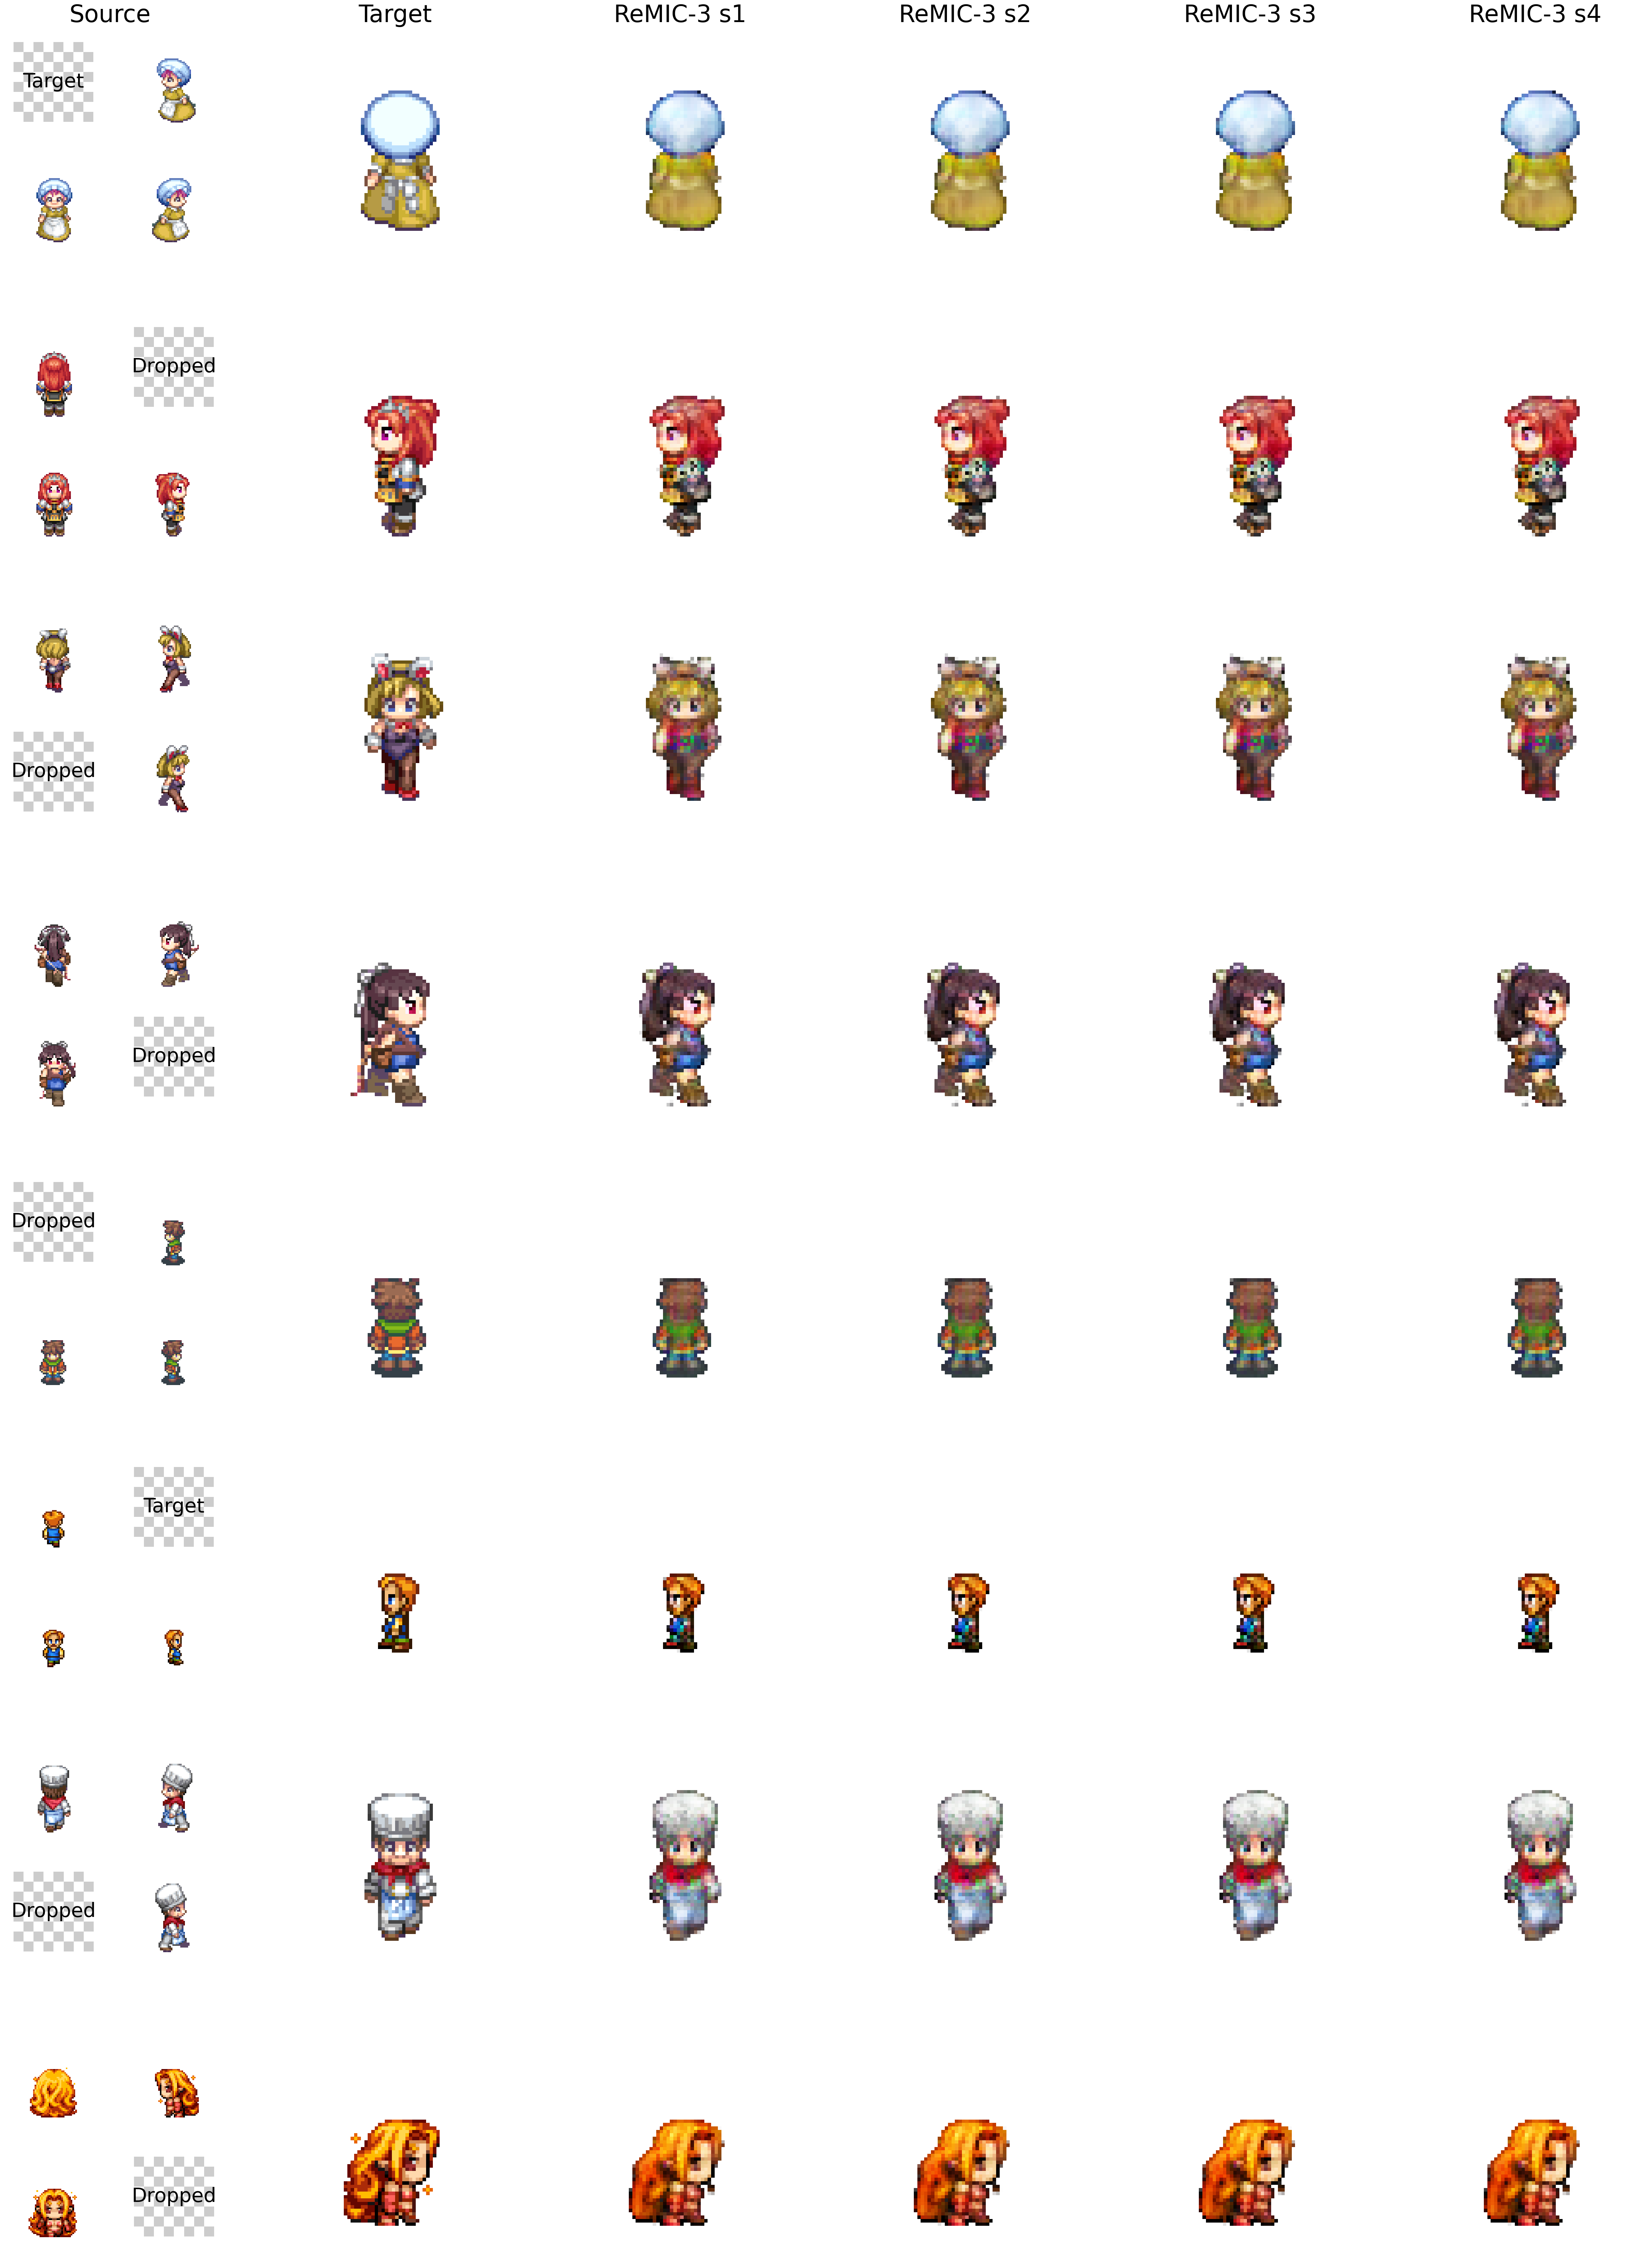

In [26]:
# display the images using imgs_params in a batch_size x 4 grid
from matplotlib import pyplot as plt
from image_utils import show_multiple_input_model_comparison

f = show_multiple_input_model_comparison(*imgs_params, model_names=["ReMIC-3 s1", "ReMIC-3 s2", "ReMIC-3 s3", "ReMIC-3 s4"])
f.patch.set_alpha(0.0)
plt.savefig("output/remic_input_comparison_style_codes.png", format="png", transparent=True)
